In [8]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

D:\Software\anaconda 1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
titanic = pd.read_csv('https://raw.githubusercontent.com/BigDataGal/Python-For-Data-Science/master/titanic-train.csv')

In [12]:
print(display(titanic.head()))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


None


In [13]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = titanic['Survived']
data = titanic.drop('Survived', axis = 1)

# Show the new dataset with 'Survived' removed
display(data.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"
    
# Test the 'accuracy_score' function
predictions = pd.Series(np.ones(5, dtype = int))
print(accuracy_score(outcomes[:5], predictions))

Predictions have an accuracy of 60.00%.


In [16]:
def predictions_0(data):
    """ Model with no features. Always predicts a passenger did not survive. """

    predictions = []
    for _, passenger in data.iterrows():
        
        # Predict the survival of 'passenger'
        predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_0(data)

In [17]:
print(accuracy_score(outcomes, predictions))

Predictions have an accuracy of 61.62%.


In [21]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def filter_data(data, condition):
    """
    Remove elements that do not match the condition provided.
    Takes a data list as input and returns a filtered list.
    Conditions should be a list of strings of the following format:
      '<field> <op> <value>'
    where the following operations are valid: >, <, >=, <=, ==, !=
    
    Example: ["Sex == 'male'", 'Age < 18']
    """

    field, op, value = condition.split(" ")
    
    # convert value into number or strip excess quotes if string
    try:
        value = float(value)
    except:
        value = value.strip("\'\"")
    
    # get booleans for filtering
    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] < value
    elif op == ">=":
        matches = data[field] >= value
    elif op == "<=":
        matches = data[field] <= value
    elif op == "==":
        matches = data[field] == value
    elif op == "!=":
        matches = data[field] != value
    else: # catch invalid operation codes
        raise Exception("Invalid comparison operator. Only >, <, >=, <=, ==, != allowed.")
    
    # filter data and outcomes
    data = data[matches].reset_index(drop = True)
    return data

def survival_stats(data, outcomes, key, filters = []):
    """
    Print out selected statistics regarding survival, given a feature of
    interest and any number of filters (including no filters)
    """
    
    # Check that the key exists
    if key not in data.columns.values :
        print("'{}' is not a feature of the Titanic data. Did you spell something wrong?".format(key))
        return False

    # Return the function before visualizing if 'Cabin' or 'Ticket'
    # is selected: too many unique categories to display
    if(key == 'Cabin' or key == 'PassengerId' or key == 'Ticket'):
        print("'{}' has too many unique categories to display! Try a different feature.".format(key))
        return False

    # Merge data and outcomes into single dataframe
    all_data = pd.concat([data, outcomes], axis = 1)
    
    # Apply filters to data
    for condition in filters:
        all_data = filter_data(all_data, condition)
    all_data = all_data[[key, 'Survived']]
    
    # Create plotting figure
    plt.figure(figsize=(8,6))

    # 'Numerical' features
    if(key == 'Age' or key == 'Fare'):
       
        # Divide the range of data into bins and count survival rates
        min_value = np.nanmin(all_data[key])
        max_value = np.nanmax(all_data[key])
        value_range = max_value - min_value

        # 'Fares' has larger range of values than 'Age' so create more bins
        if(key == 'Fare'):
            bins = np.arange(0, all_data['Fare'].max() + 20, 20)
        if(key == 'Age'):
            bins = np.arange(0, all_data['Age'].max() + 10, 10)
        
        # Overlay each bin's survival rates
        nonsurv_vals = all_data[all_data['Survived'] == 0][key].reset_index(drop = True)
        surv_vals = all_data[all_data['Survived'] == 1][key].reset_index(drop = True)
        plt.hist(nonsurv_vals, bins = bins, alpha = 0.6, range=(bins.min(),bins.max()),
                 color = 'red', label = 'Did not survive')
        plt.hist(surv_vals, bins = bins, alpha = 0.6, range=(bins.min(),bins.max()),
                 color = 'green', label = 'Survived')
    
        # Add legend to plot
        plt.xlim(0, bins.max())
        plt.legend(framealpha = 0.8)
    
    # 'Categorical' features
    else:
       
        # Set the various categories
        if(key == 'Pclass'):
            values = np.arange(1,4)
        if(key == 'Parch' or key == 'SibSp'):
            values = np.arange(0, np.nanmax(data[key]) + 1)
        if(key == 'Embarked'):
            values = ['C', 'Q', 'S']
        if(key == 'Sex'):
            values = ['male', 'female']

        # Create DataFrame containing categories and count of each
        frame = pd.DataFrame(index = np.arange(len(values)), columns=(key,'Survived','NSurvived'))
        for i, value in enumerate(values):
            frame.loc[i] = [value, \
                   len(all_data[(all_data['Survived'] == 1) & (all_data[key] == value)]), \
                   len(all_data[(all_data['Survived'] == 0) & (all_data[key] == value)])]

        # Set the width of each bar
        bar_width = 0.4

        # Display each category's survival rates
        for i in np.arange(len(frame)):
            nonsurv_bar = plt.bar(i-bar_width, frame.loc[i]['NSurvived'], width = bar_width, color = 'r')
            surv_bar = plt.bar(i, frame.loc[i]['Survived'], width = bar_width, color = 'g')

            plt.xticks(np.arange(len(frame)), values)
            plt.legend((nonsurv_bar[0], surv_bar[0]),('Did not survive', 'Survived'), framealpha = 0.8)

    # Common attributes for plot formatting
    plt.xlabel(key)
    plt.ylabel('Number of Passengers')
    plt.title('Passenger Survival Statistics With \'%s\' Feature'%(key))
    plt.show()

    # Report number of passengers with missing values
    if sum(pd.isnull(all_data[key])):
        nan_outcomes = all_data[pd.isnull(all_data[key])]['Survived']
        print("Passengers with missing '{}' values: {} ({} survived, {} did not survive)".format( \
              key, len(nan_outcomes), sum(nan_outcomes == 1), sum(nan_outcomes == 0)))

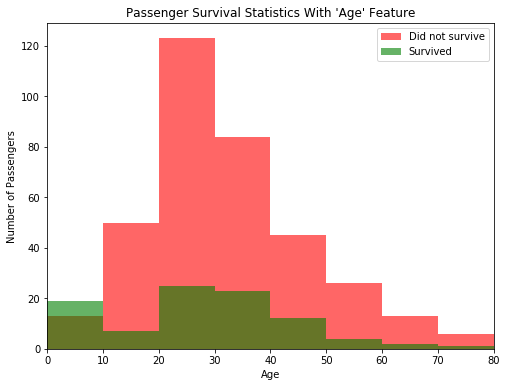

Passengers with missing 'Age' values: 124 (16 survived, 108 did not survive)


In [22]:
survival_stats(data, outcomes, 'Age', ["Sex == 'male'"])

In [23]:
def predictions_2(data):
    """ Model with two features: 
            - Predict a passenger survived if they are female.
            - Predict a passenger survived if they are male and younger than 10. """
    
    predictions = []
    for _, passenger in data.iterrows():       
        if passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            if passenger['Age'] < 10:
                predictions.append(1)
            else:
                predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_2(data)

In [24]:
print(accuracy_score(outcomes, predictions))

Predictions have an accuracy of 79.35%.


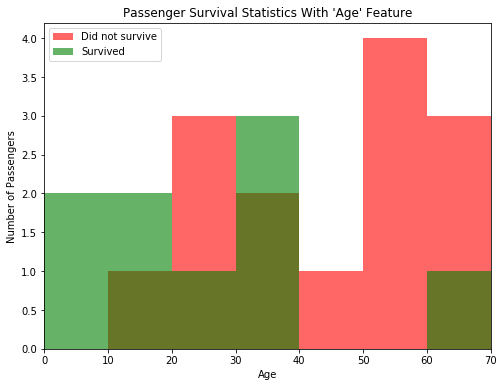

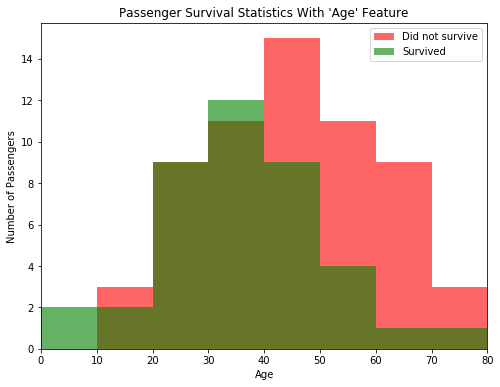

Passengers with missing 'Age' values: 21 (5 survived, 16 did not survive)


In [25]:
survival_stats(data, outcomes, 'Age', ["Sex == 'male'", "Pclass == 1", "Parch > 0"])

survival_stats(data, outcomes, 'Age', ["Sex == 'male'", "Pclass == 1"])

In [26]:
def predictions_3(data):
    """ Model with multiple features. Makes a prediction with an accuracy of at least 80%. """
    
    predictions = []
    for _, passenger in data.iterrows():
        if passenger['Sex'] == 'female':
            if passenger['Age'] > 40 and passenger['Age'] < 60 and passenger['Pclass'] == 3:
                predictions.append(0)
            else:
                predictions.append(1)
        else:
            if passenger['Age'] <= 10:
                predictions.append(1)
            elif passenger['Pclass'] == 1 and passenger['Age'] <= 40:
                predictions.append(1)
            else:
                predictions.append(0)
        
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_3(data)

In [27]:
print(accuracy_score(outcomes, predictions))

Predictions have an accuracy of 80.02%.
